In [1]:
%%capture
cd ..

In [2]:
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics

from palma import Project, ModelEvaluation, ModelSelector
from palma.components import ScoringAnalysis, ShapAnalysis
from palma.utils import plotting

In [3]:
from palma.datasets import load_credit_approval
from palma.components import FileSystemLogger
from palma import set_logger

set_logger(FileSystemLogger("logger"))
X, y = load_credit_approval()

**Create the project**
To create vanilla project (without components), only input data $X$, target data $y$ and validation method needs to be provided

In [4]:
project = Project(problem="classification", project_name="test")
project.start(
    X, y,
    splitter=model_selection.ShuffleSplit(n_splits=4, random_state=42))

C:\Users\Vincent LAURENT\PROJETS\tools\palma_dev\.env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Here are representation of the validation strategy
* For validation steps
* For test steps

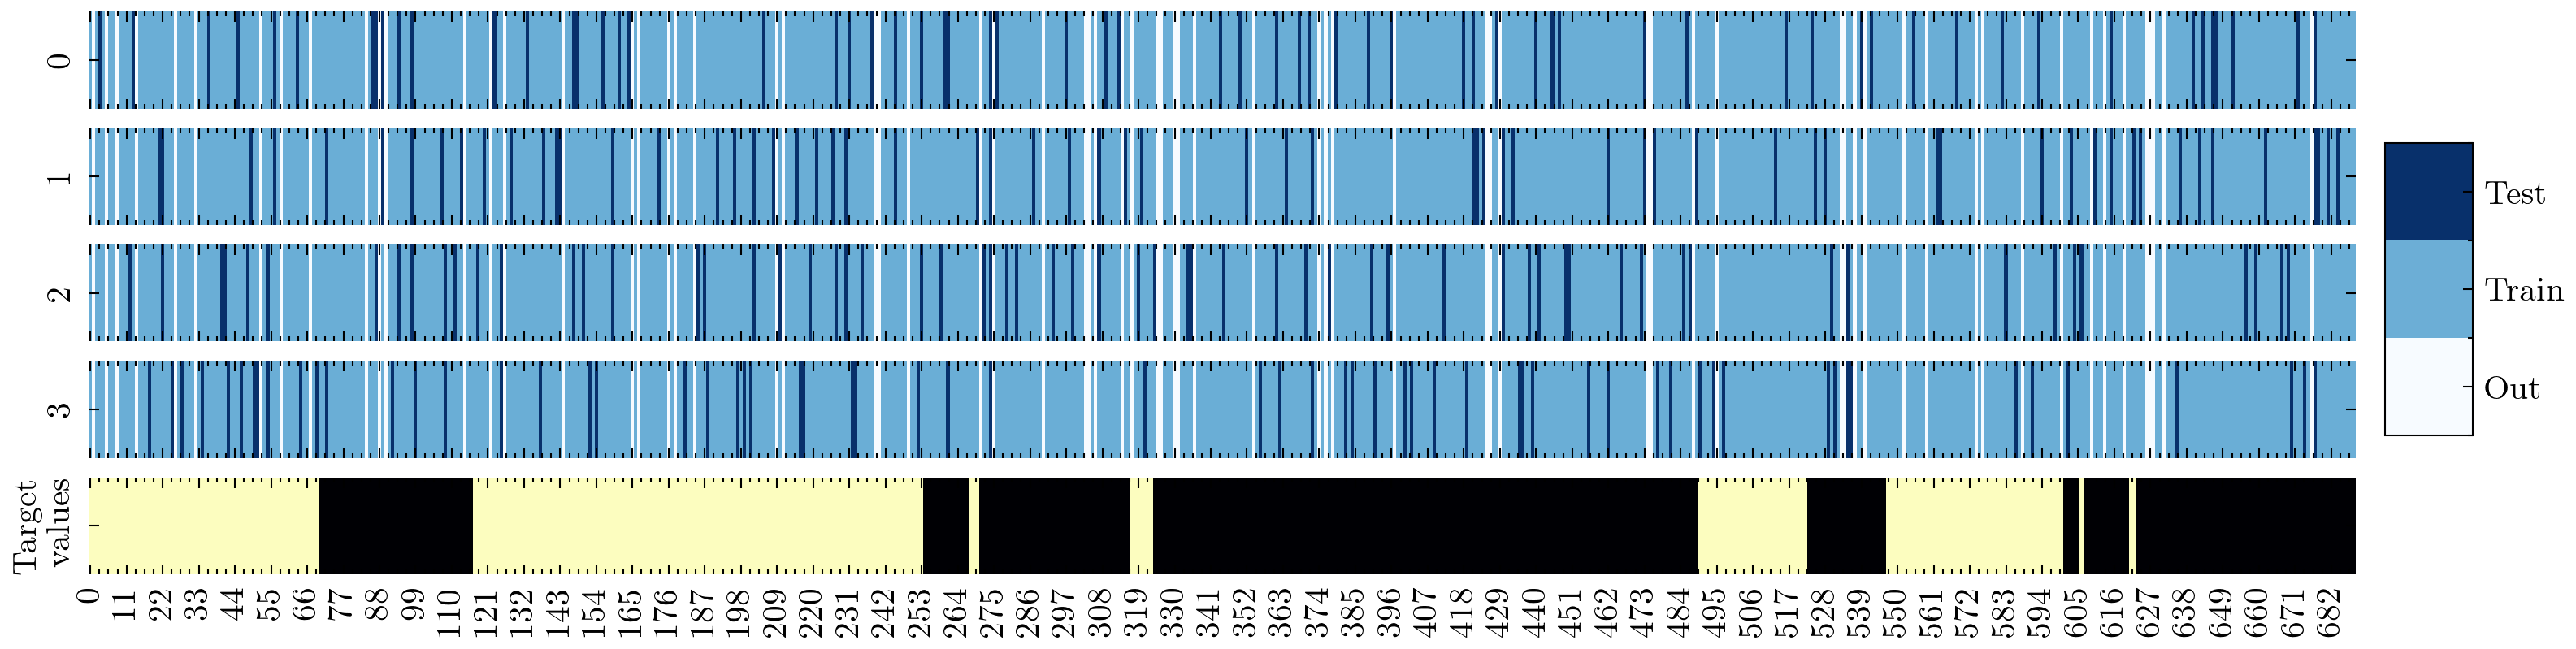

In [5]:
res = plotting.plot_splitting_strategy(
    project.X, project.y,
    iter_cross_validation=project.validation_strategy.indexes_val,
    cmap="rainbow_r")

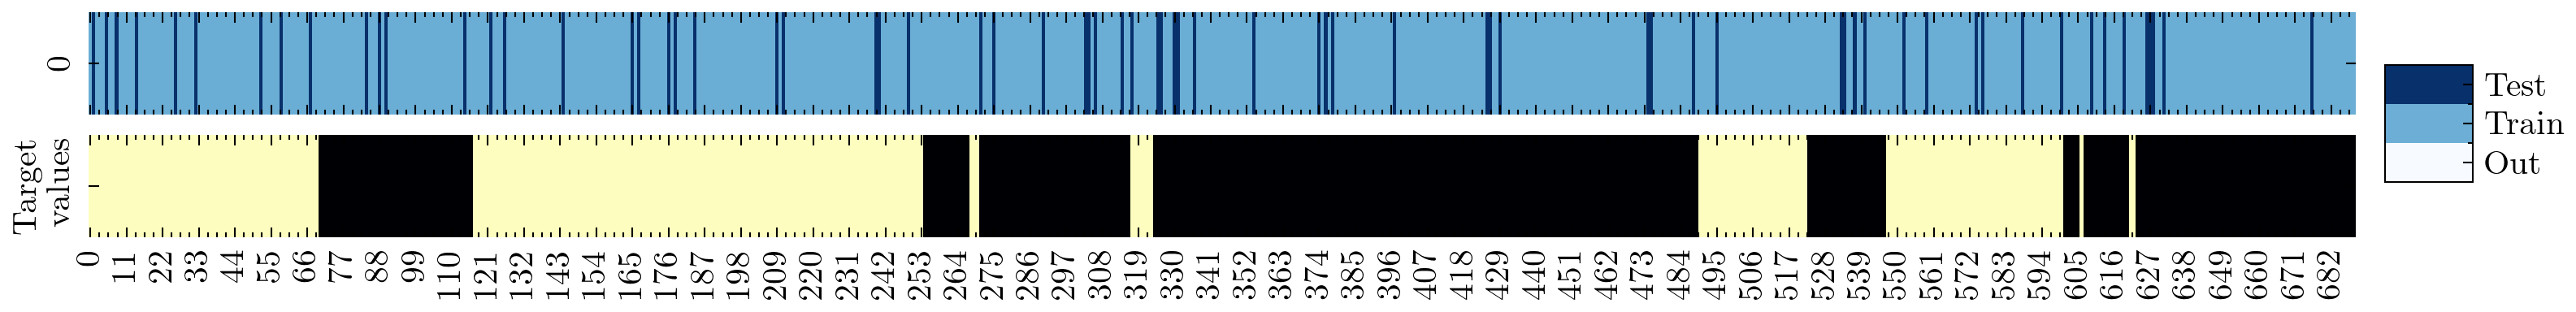

In [6]:
res = plotting.plot_splitting_strategy(
    project.X, project.y,
    iter_cross_validation=project.validation_strategy.indexes_train_test,
    cmap="rainbow_r")

**Run Opimization** 
Using the FLAML library, the best model (in a given estimator family) is searched

In [7]:
%%capture
ms = ModelSelector(engine="FlamlOptimizer",
                   engine_parameters=dict(time_budget=20))
ms.start(project)

In [8]:
ms.best_model_

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8831396087236489, colsample_bynode=None,
              colsample_bytree=0.9119223562675598, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.19570530468002195,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=11,
              min_child_weight=0.12166259220855588, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=15,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

**Analyse model** Once the best parameters and model is found, use the `ModelEvaluation` api to assess performance. Several built-in component are provided :
- `ScoringAnalysis`
- `RegressionAnalysis`
- `ShapAnalysis`

They can be related to either validation indexes (optimized by `ModelSelector`) or train/test indexes 

In [9]:
%%capture
model = ModelEvaluation(estimator=ms.best_model_)
model.add(ScoringAnalysis(on="indexes_val"))
model.add(ShapAnalysis(on="indexes_val", n_shap=100))
model.fit(project)

In [10]:
analyser = model.components["ScoringAnalysis"]
shap_analyser = model.components["ShapAnalysis"]

C:\Users\Vincent LAURENT\PROJETS\tools\palma_dev\palma\utils\plotting.py:195: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



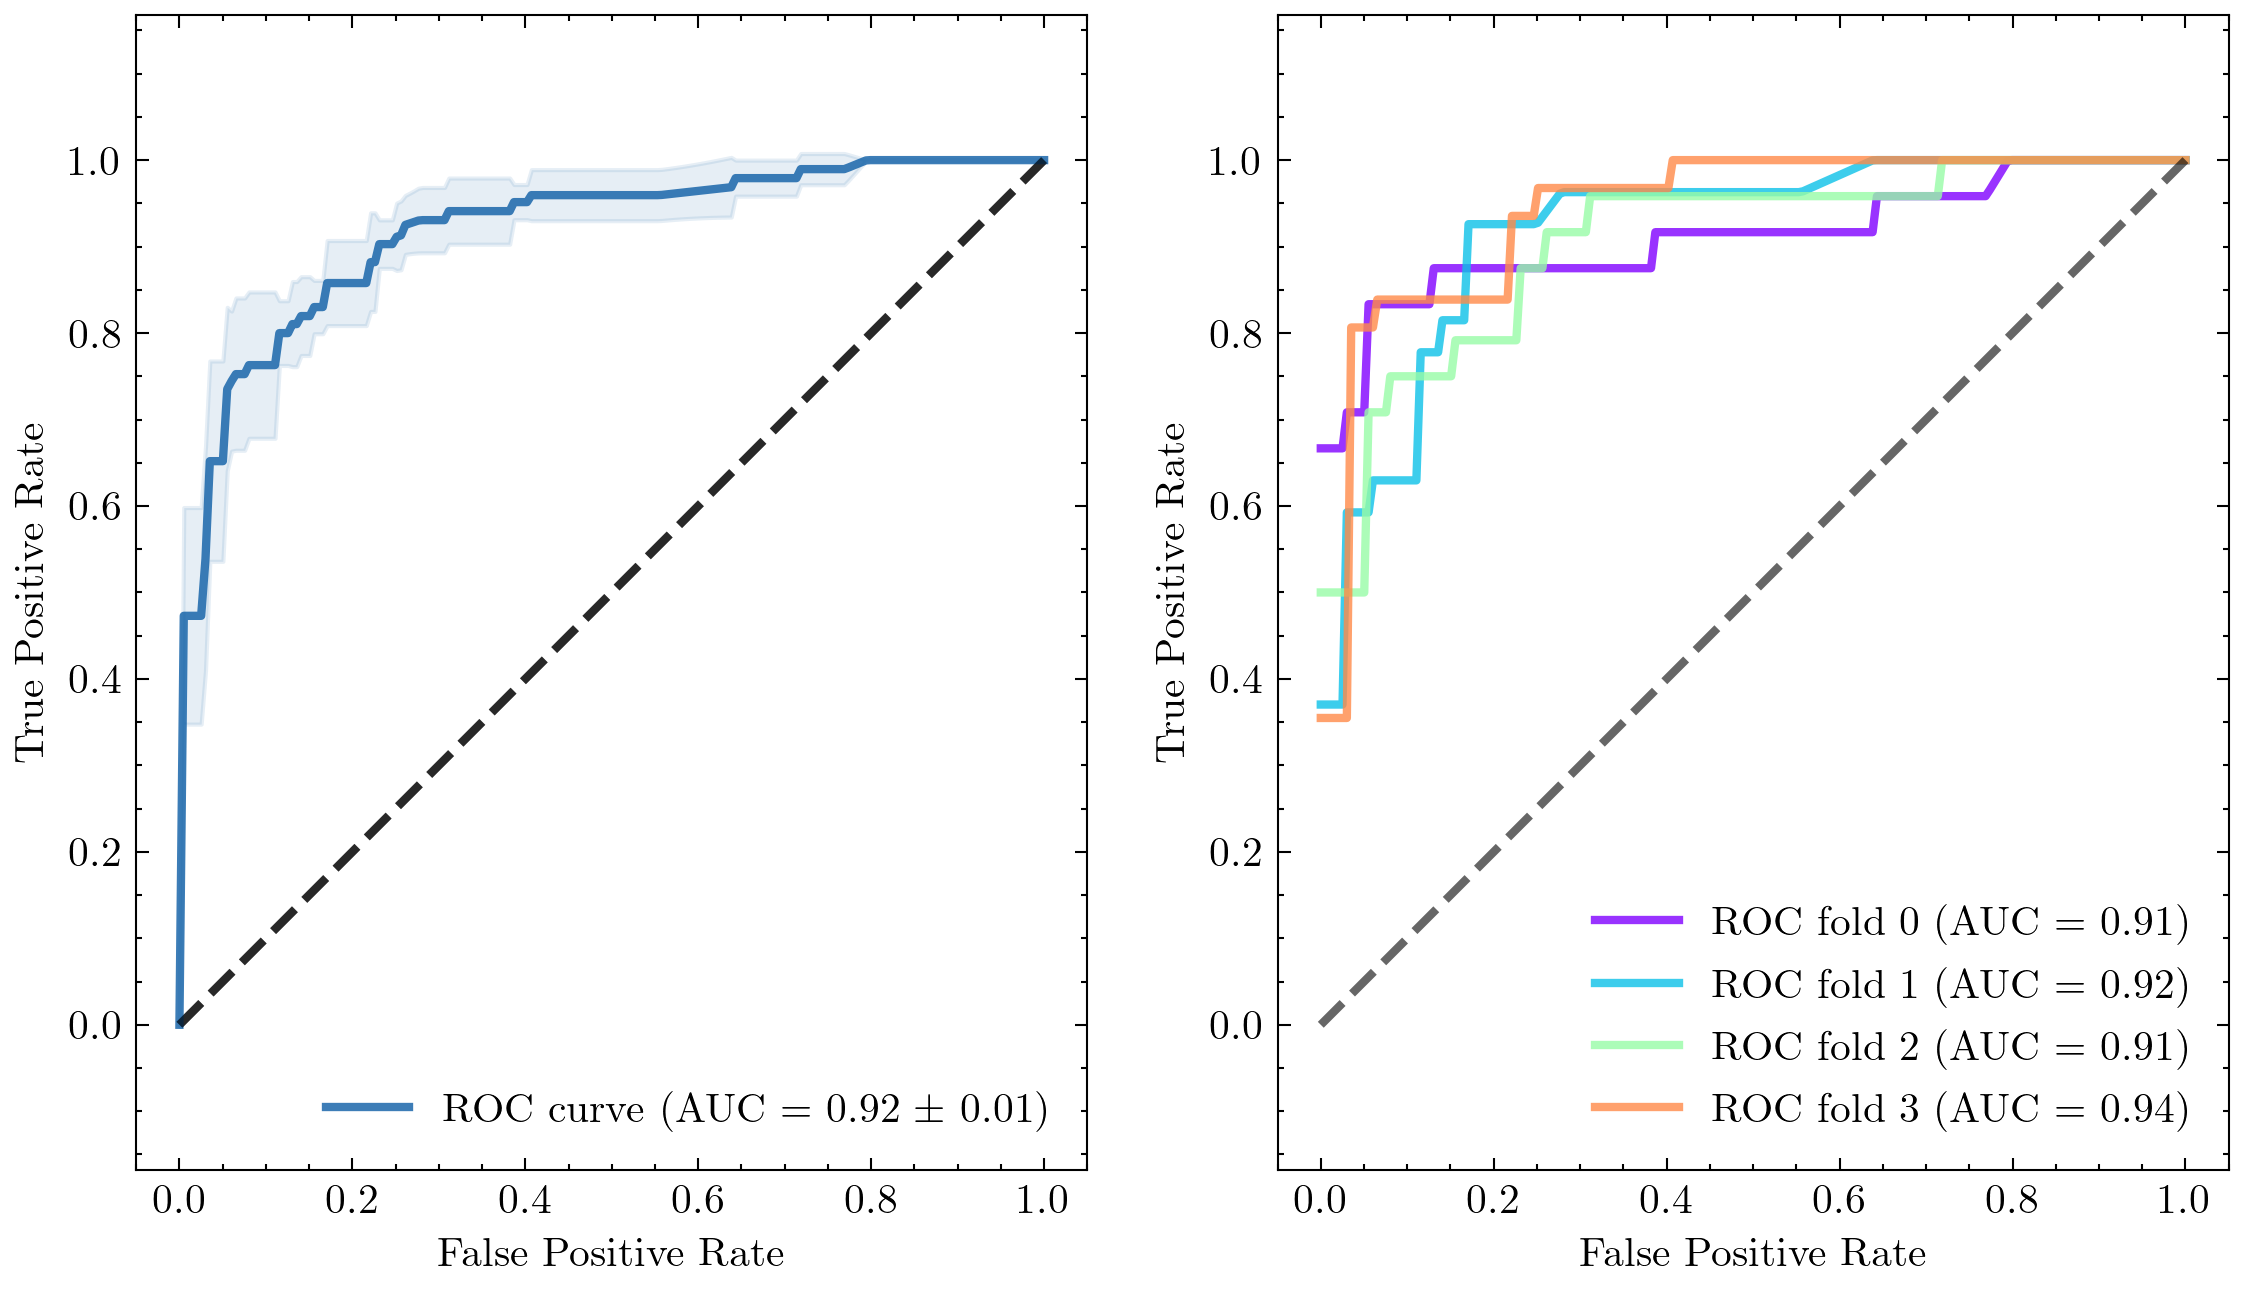

In [11]:
f, ax = plt.subplots(figsize=(9, 5), ncols=2)

plt.sca(ax[0])
analyser.plot_roc_curve(plot_method="beam")
analyser.plot_roc_curve(plot_method="mean")
plt.sca(ax[1])
analyser.plot_roc_curve(plot_method="all", cmap="rainbow")
plt.show()


**[FOCUS] Explanantion tools**

1 . variable importance

C:\Users\Vincent LAURENT\PROJETS\tools\palma_dev\palma\utils\plotting.py:97: FutureWarning:

Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.



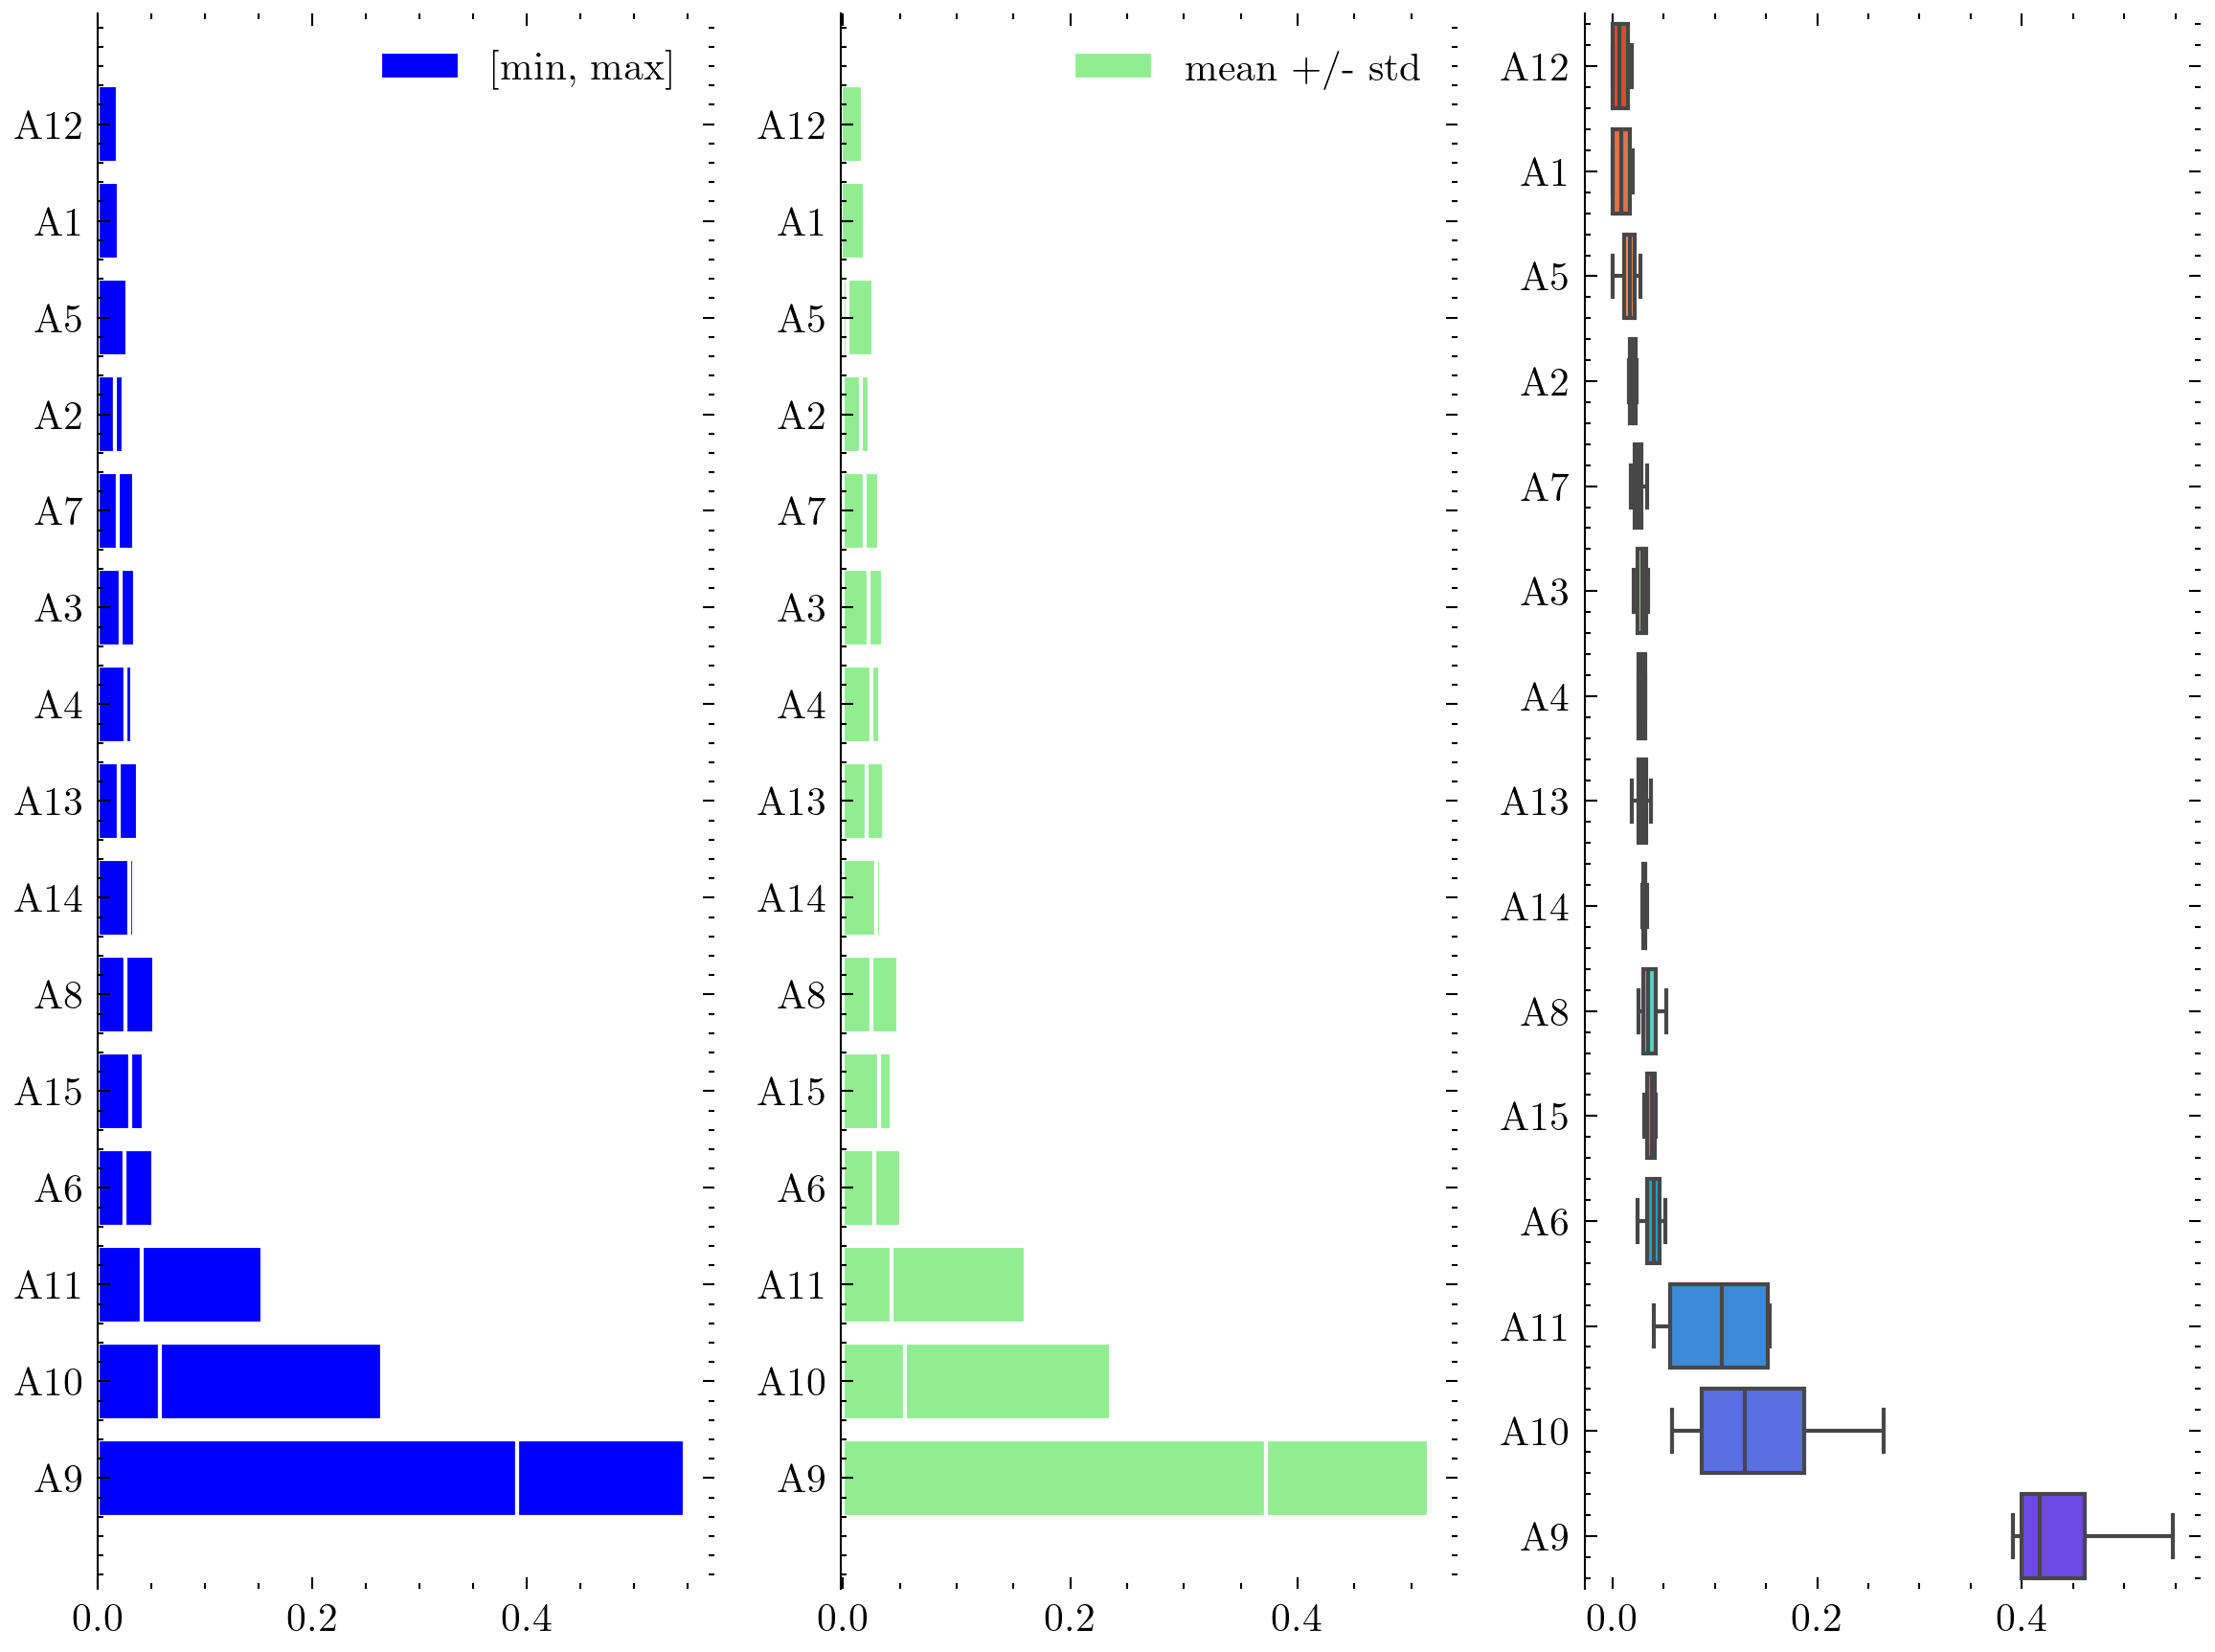

,0,1,2,3
A1,0.016771,0.019559,0.0,0.0
A2,0.023943,0.015941,0.021778,0.017714
A3,0.032335,0.025956,0.020874,0.034913
A4,0.032318,0.025464,0.031705,0.025623
A5,0.019149,0.027651,0.014785,0.0
A6,0.036911,0.024789,0.044673,0.05189
A7,0.022877,0.02667,0.018402,0.033818
A8,0.052549,0.03111,0.039096,0.025543
A9,0.432583,0.547696,0.402609,0.391129
A10,0.05774,0.097139,0.264596,0.161868


In [12]:
f, ax = plt.subplots(figsize=(8, 6), ncols=3)
plt.sca(ax[0])
analyser.plot_variable_importance(mode="minmax", color="blue")
plt.sca(ax[1])
analyser.plot_variable_importance(mode="std", color="lightgreen")
plt.sca(ax[2])
analyser.plot_variable_importance(mode="boxplot", cmap="rainbow_r")
plt.show()
analyser.variable_importance()

2. shap explanation 

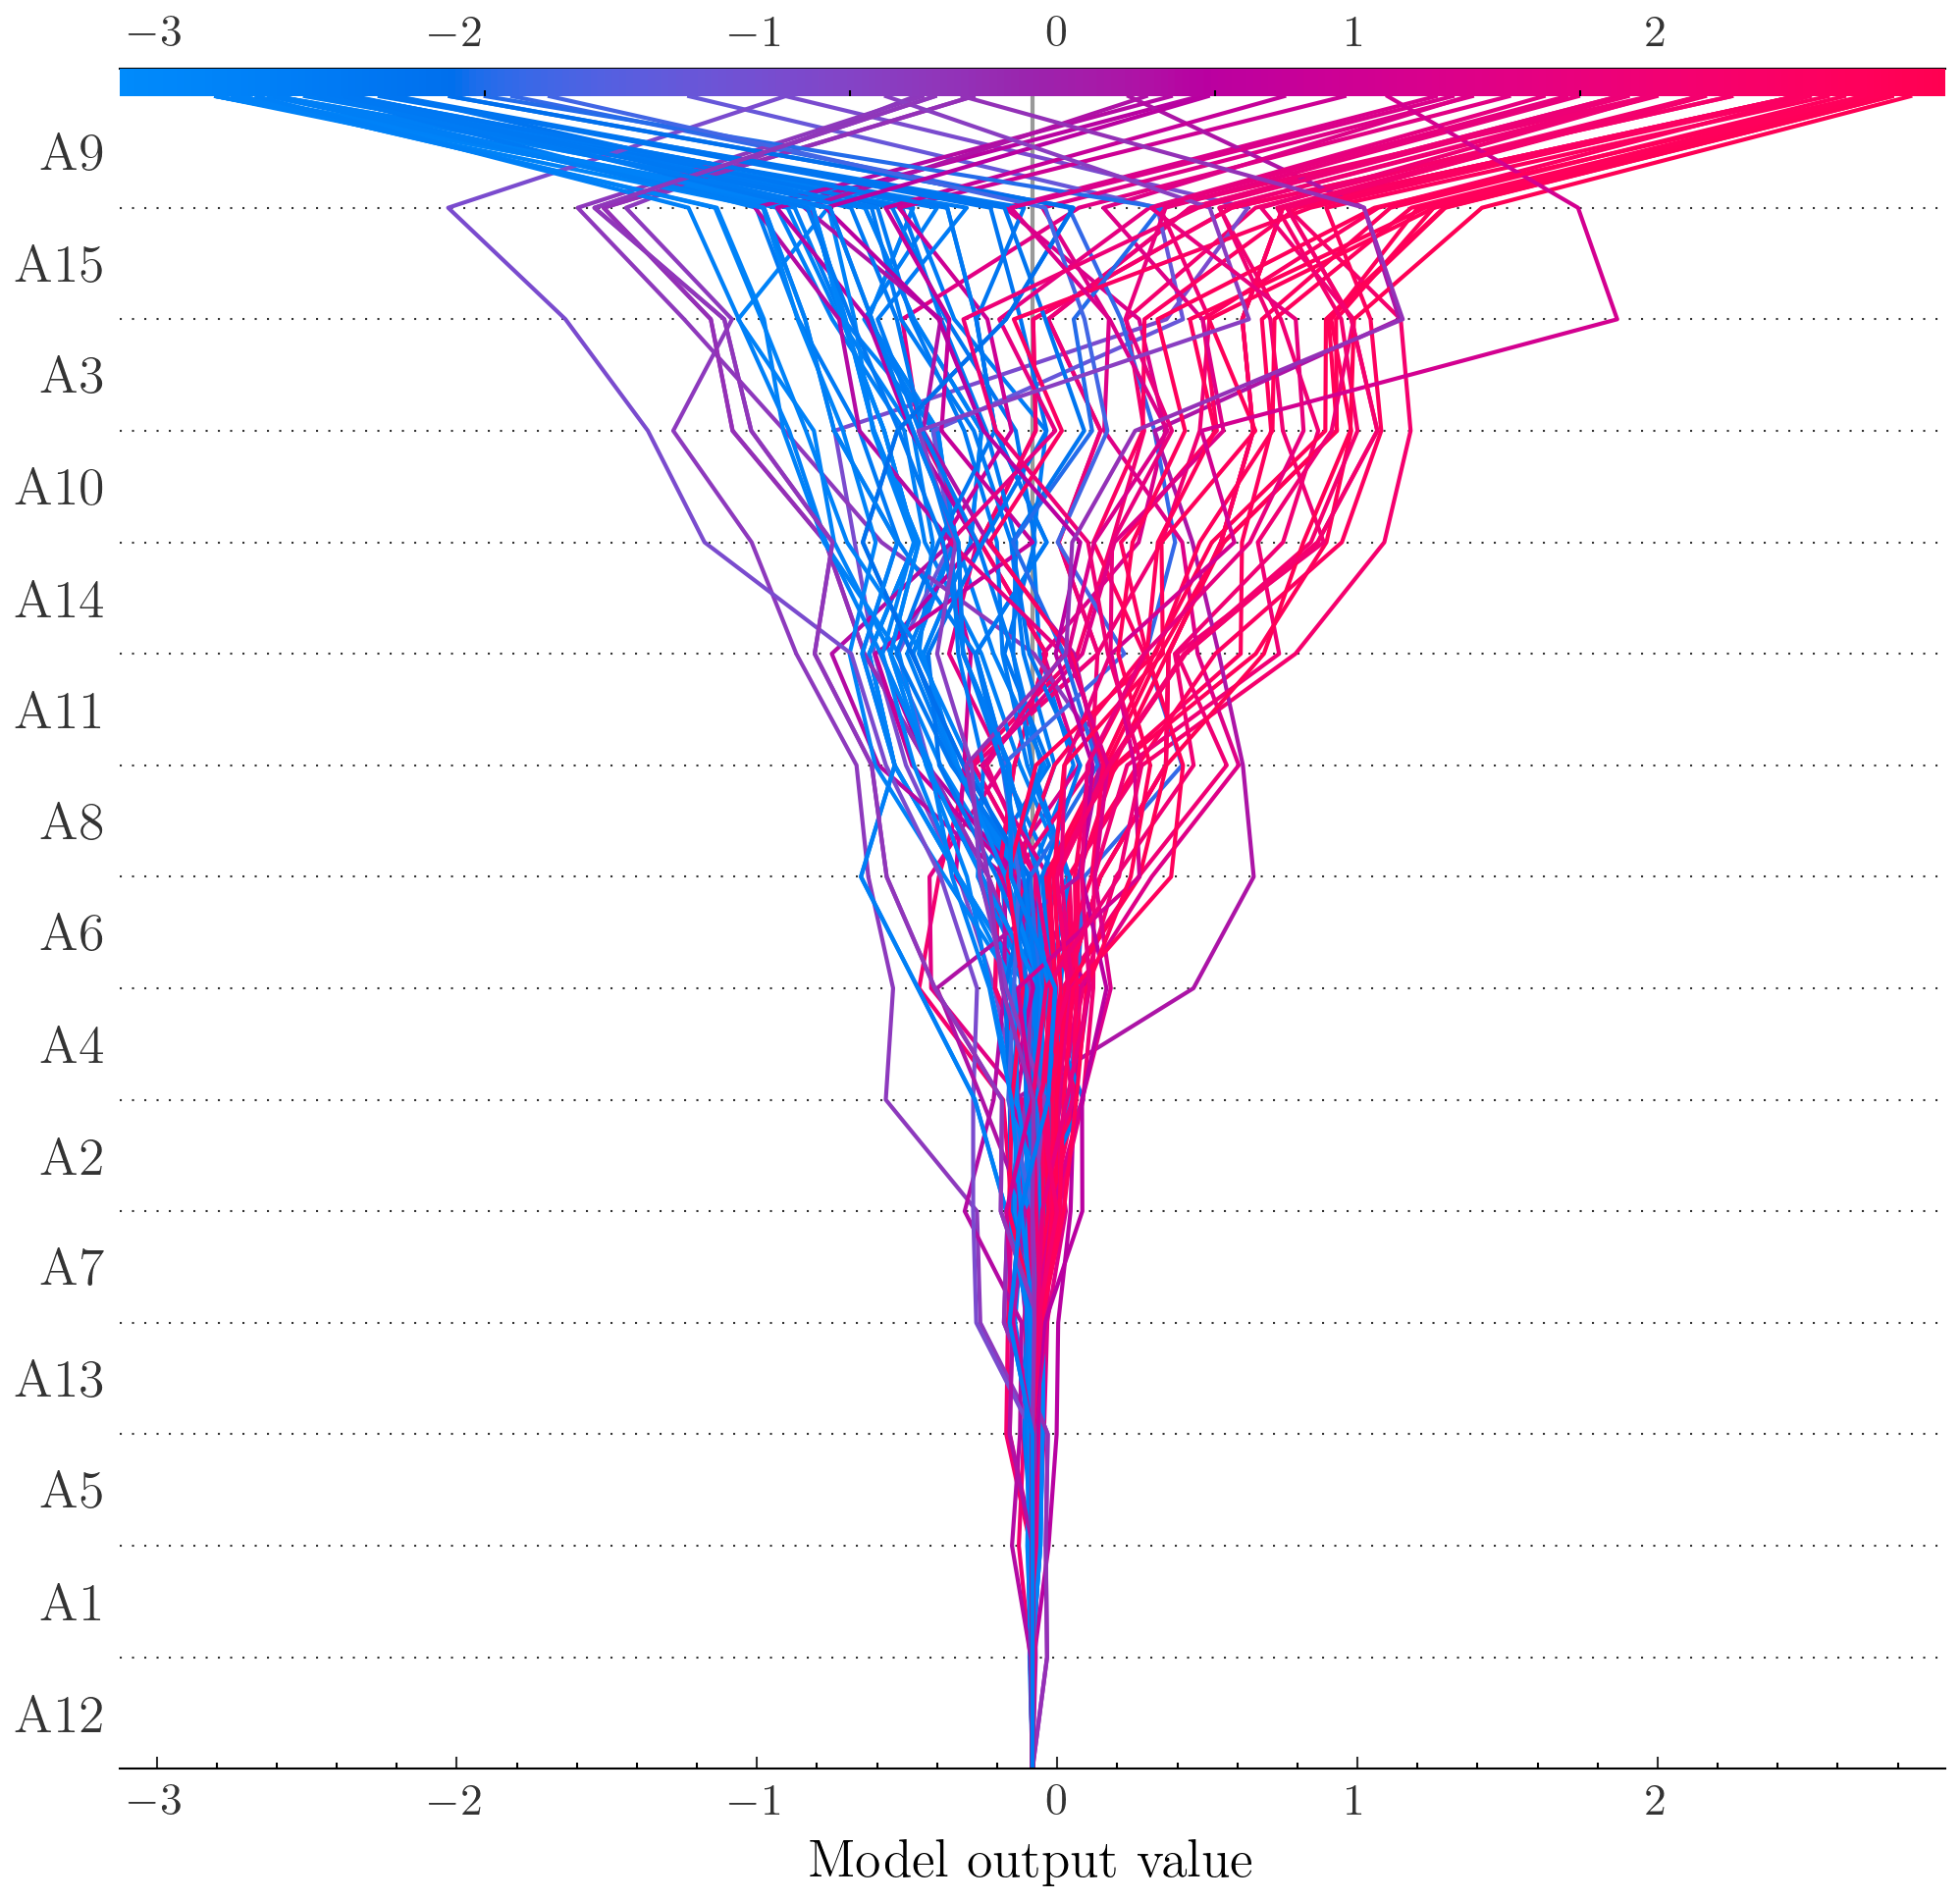

<Figure size 1050x1050 with 0 Axes>

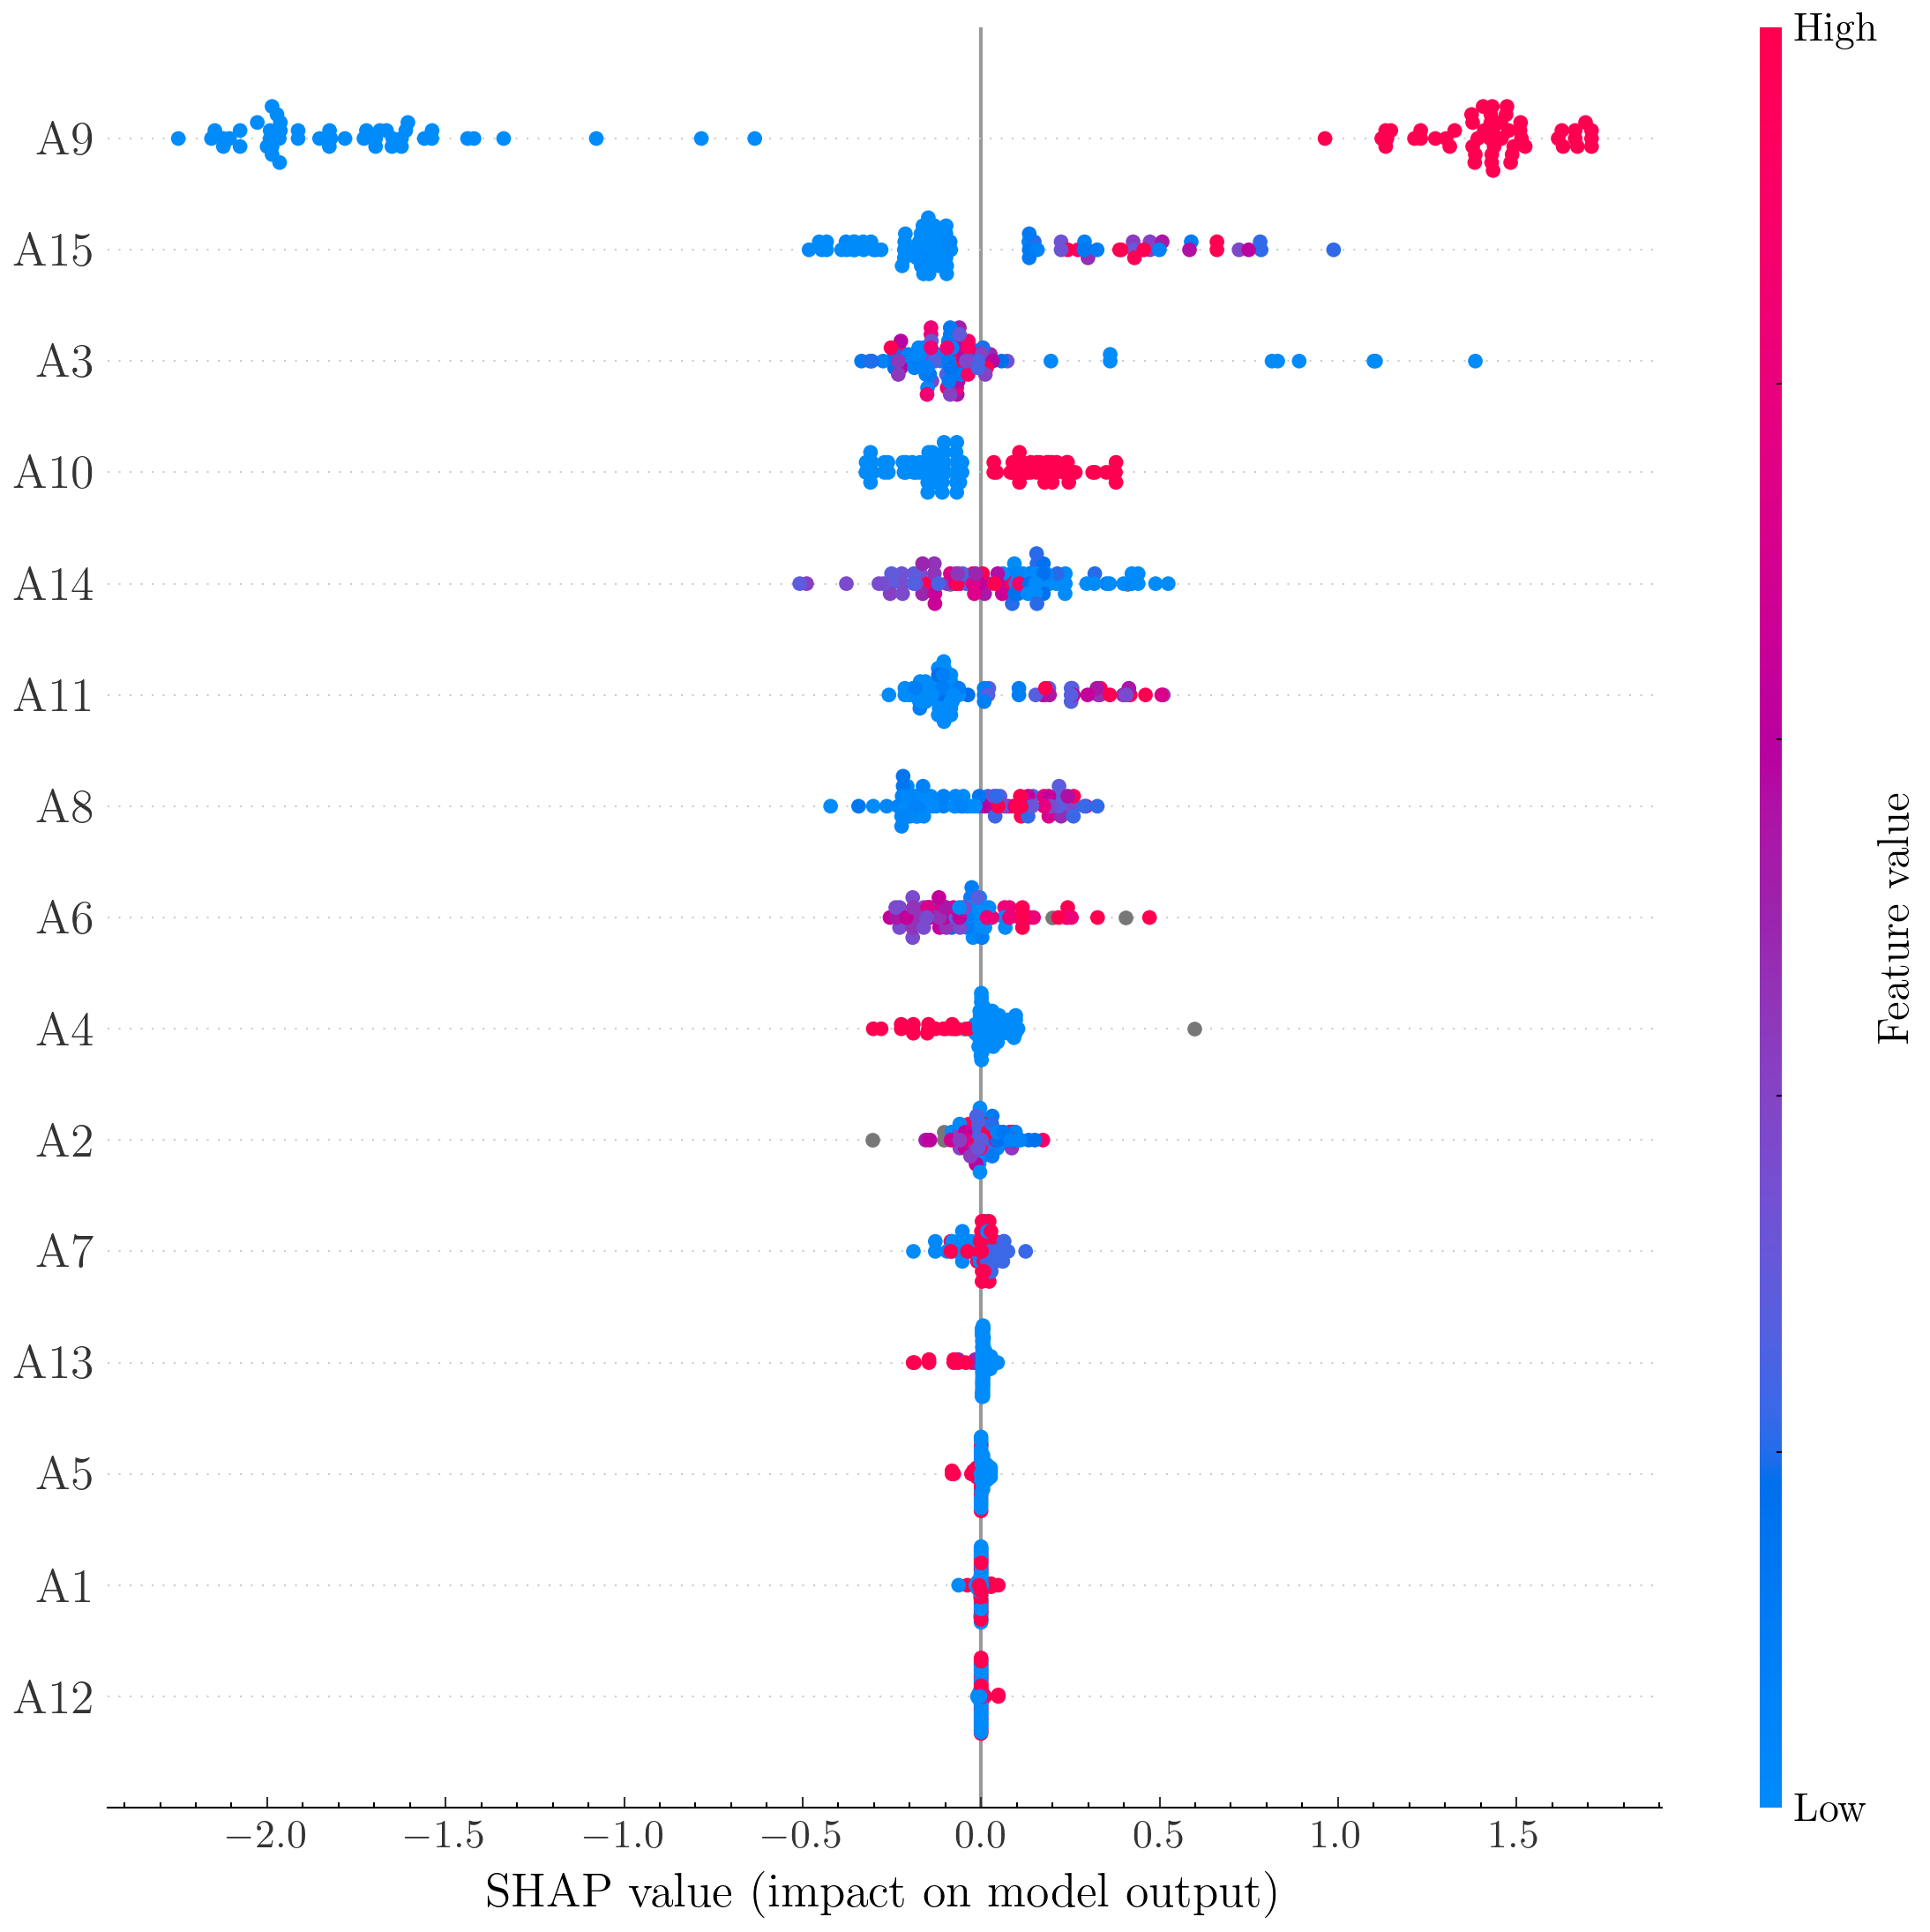

<Figure size 1050x1050 with 0 Axes>

In [13]:
plt.figure(figsize=(5, 5))
shap_analyser.plot_shap_decision_plot()
plt.figure(figsize=(5, 5))
shap_analyser.plot_shap_summary_plot()

**Compute classification threshold**
Three methods are available to set the classification threshold

1. Corresponding to a provided fractile of the population targeted to one
2. Corresponding to a provided fractile of the positive true rate (recall) targeted to one
3. Corresponding to the optimized value of a provided metric

In [14]:
print(analyser.compute_threshold(method="total_population", value=0.5))
print(analyser.compute_threshold(method="fpr", value=0.5))
print(analyser.compute_threshold(method="optimize_metric",
                                 metric=metrics.accuracy_score))

0.052492620712146165
0.08254301618360346
0.60426426


**Confusion matrix** corresponding to target 50% of the total population

In [15]:
analyser.compute_threshold(method="total_population", value=0.5)
analyser.confusion_matrix(in_percentage=True)

,predicted : 0,predicted : 1
real : 0,0.5,52.9
real : 1,0.0,46.7


**Confusion matrix** corresponding to an accpetance of 50% of false positive rate 

In [16]:
analyser.compute_threshold(method="fpr", value=0.5)
analyser.confusion_matrix(in_percentage=True)


,predicted : 0,predicted : 1
real : 0,26.3,26.8
real : 1,0.5,46.4


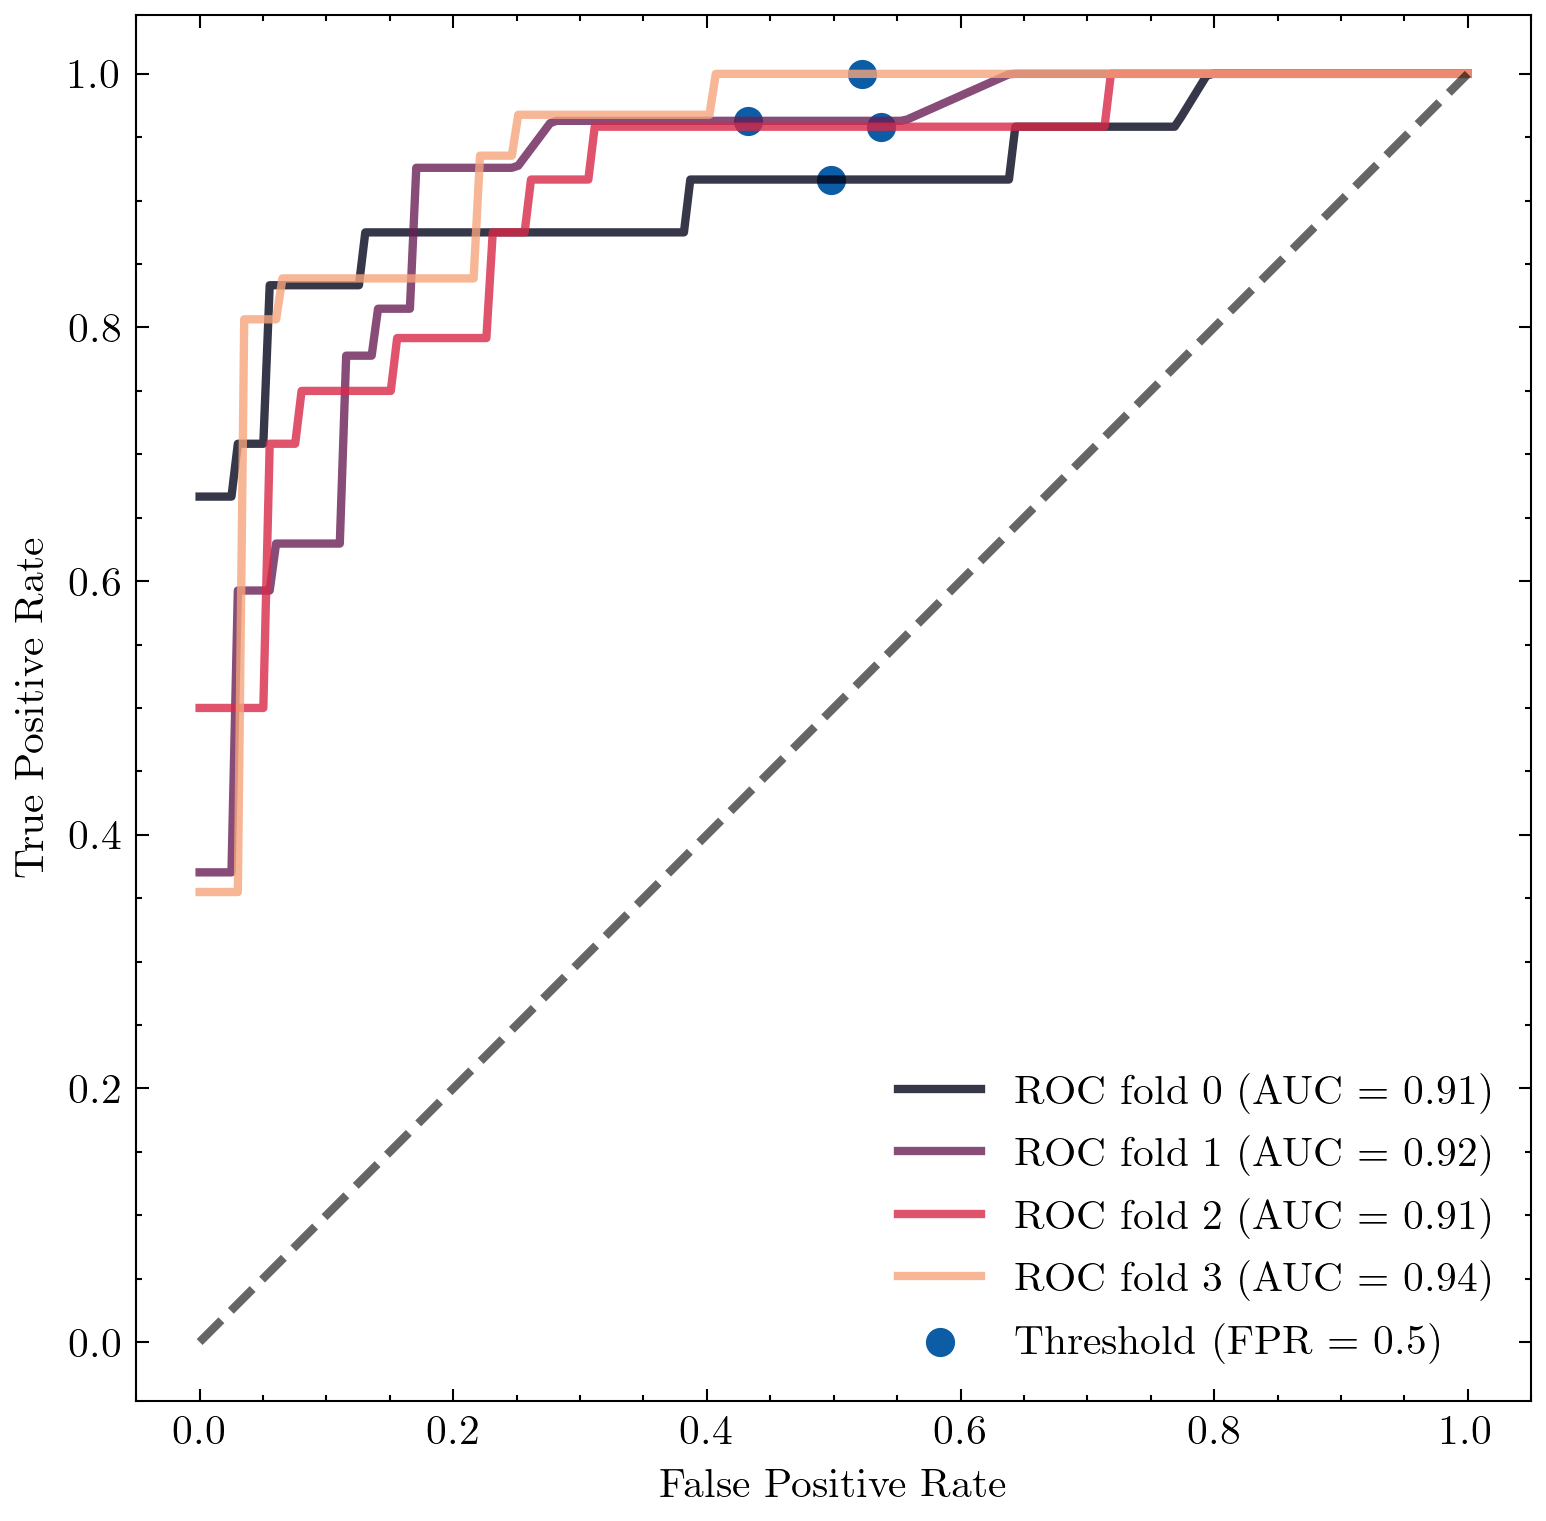

In [17]:
plt.figure(figsize=(6, 6))

analyser.plot_roc_curve(plot_method="all", cmap="rocket")
analyser.plot_threshold(label="Threshold (FPR = 0.5)")
plt.legend(loc=4)
